Arudur

Acceleration, Velocity, Displacement

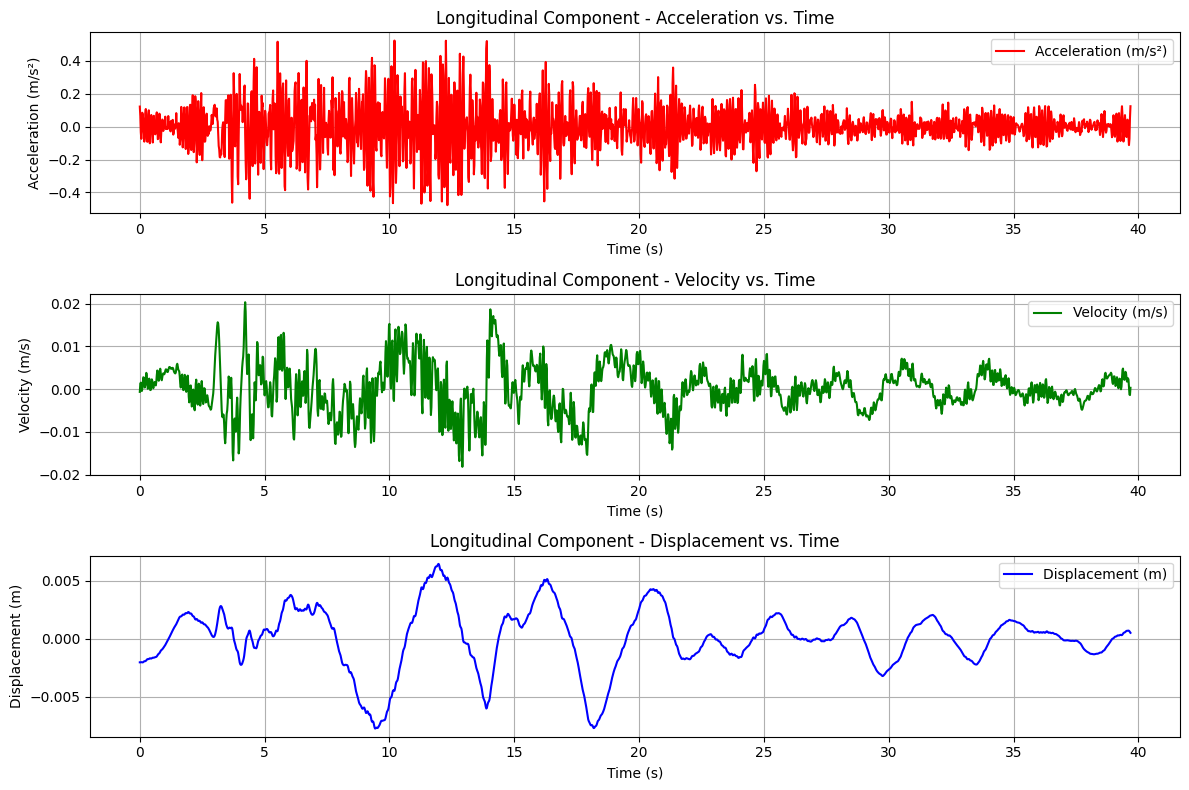

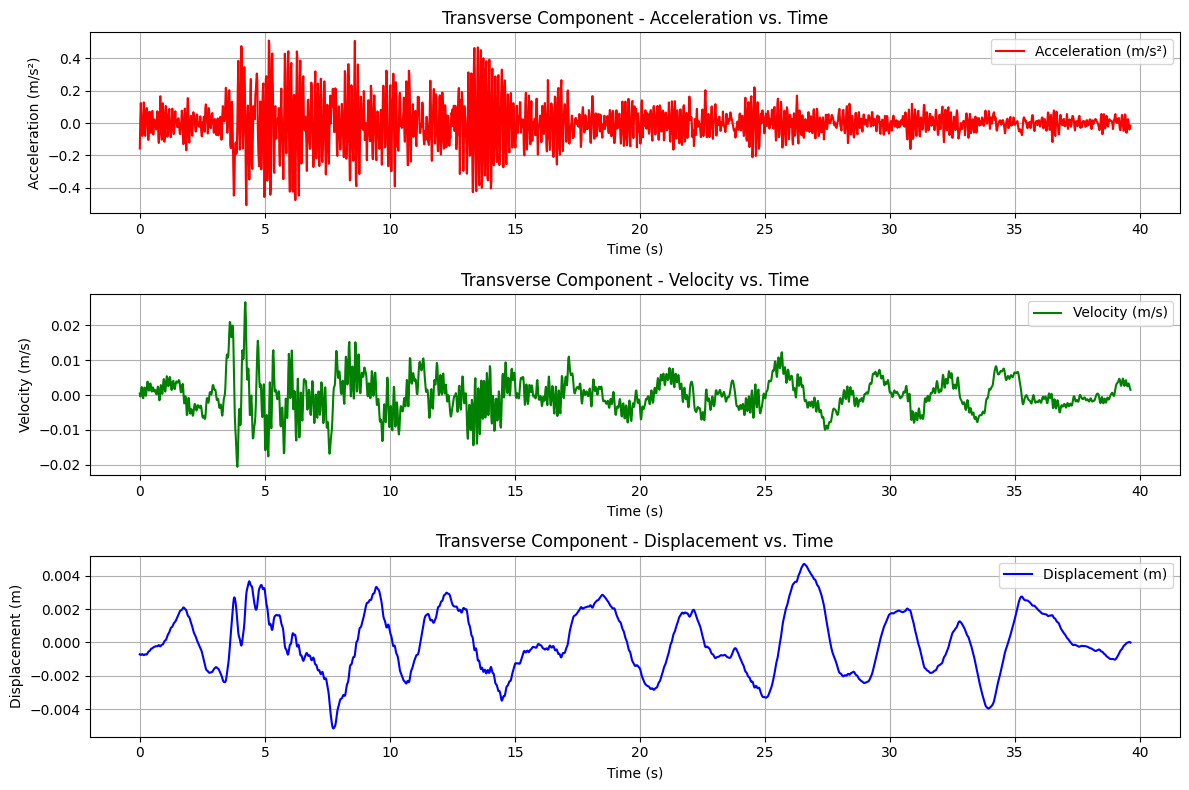

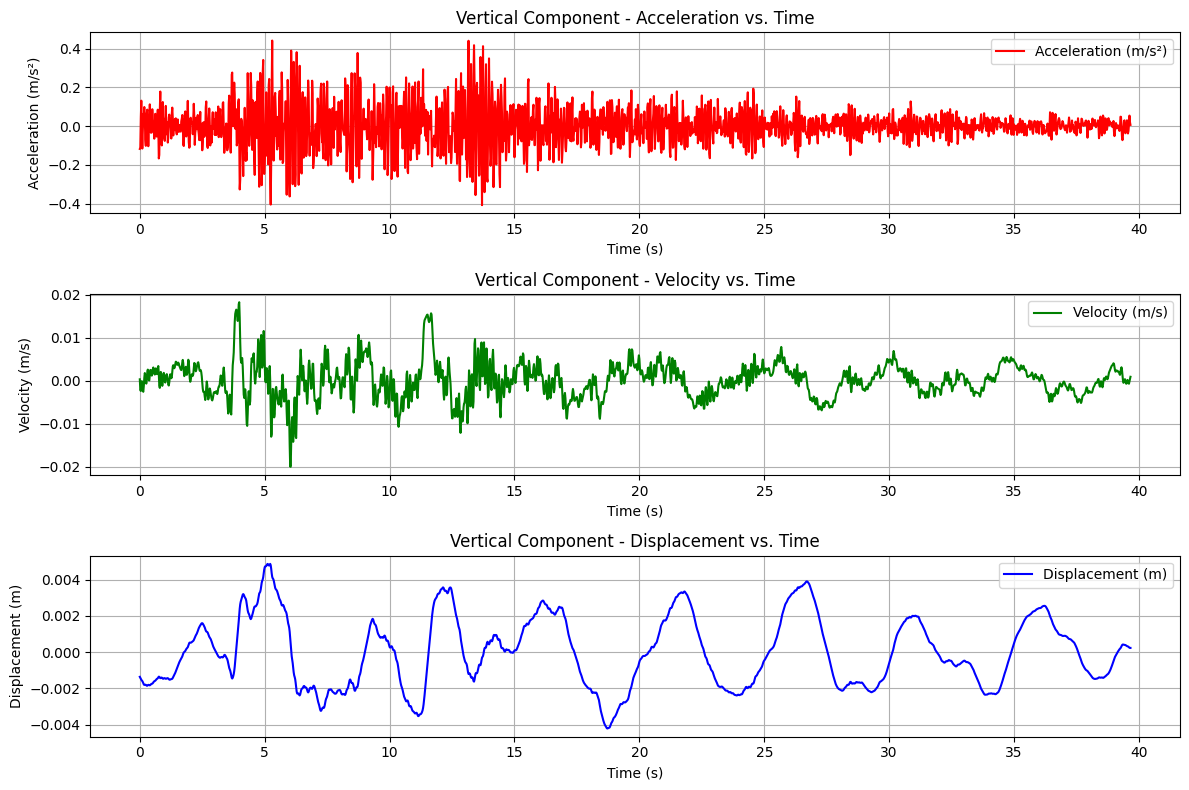


Longitudinal Component:
Velocity (first 5 values): [-0.00064671  0.00118879  0.00151711  0.00046474 -0.000445  ]
Displacement (first 5 values): [-0.00202755 -0.0020286  -0.00201974 -0.00201244 -0.00202145]

Transverse Component:
Velocity (first 5 values): [ 0.00043952 -0.00040484  0.00040931  0.00201295  0.00229215]
Displacement (first 5 values): [-0.00070752 -0.0007323  -0.00074366 -0.00073248 -0.00070692]

Vertical Component:
Velocity (first 5 values): [ 0.00028836 -0.00213346 -0.00243006 -0.00101242 -0.0001419 ]
Displacement (first 5 values): [-0.00136419 -0.00141185 -0.00147103 -0.00152692 -0.00156417]


In [ ]:
import numpy as np
import scipy.signal as signal
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import pandas as pd

def read_acceleration_file(filename):
    """Reads an earthquake acceleration data file and extracts metadata + acceleration values."""
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Extract time step (delt)
    for line in lines:
        if "Acceleration data points" in line and "sec" in line:
            words = line.split()
            for i, word in enumerate(words):
                if word == "at":
                    try:
                        delt = float(words[i + 1])  # Extract time step
                        break
                    except ValueError:
                        raise ValueError(f"Error parsing time step from line: {line}")
            break
    else:
        raise ValueError("Could not find time step in file.")

    # Extract acceleration values
    acc_data = []
    data_section = False
    for line in lines:
        if "Acceleration data points" in line:
            data_section = True
            continue

        if data_section:
            try:
                acc_values = list(map(float, line.replace("E", "e").split()))
                acc_data.extend(acc_values)
            except ValueError:
                break  # Stop reading on non-numeric data

    if not acc_data:
        raise ValueError("No acceleration data found in file.")

    return np.array(acc_data), delt

def acc_to_disp(acc, delt):
    """Computes velocity and displacement from acceleration using integration and filtering."""
    t = np.arange(len(acc)) * delt

    # Compute velocity and displacement using numerical integration
    velocity = integrate.cumulative_trapezoid(acc, t, initial=0)
    displacement = integrate.cumulative_trapezoid(velocity, t, initial=0)

    # Apply Butterworth filter
    fo = 0.1  # Lower cutoff frequency
    fc = 1 / (2 * delt)  # Nyquist frequency
    nf = 0.5 * fc  # Upper cutoff (set to avoid aliasing)
    b, a = signal.butter(4, np.array([fo, nf]) / fc, btype='bandpass')

    velocity_filtered = signal.filtfilt(b, a, velocity)
    displacement_filtered = signal.filtfilt(b, a, displacement)

    return t, velocity_filtered, displacement_filtered

def plot_results(component, t, acc, velocity, displacement):
    """Plots Acceleration, Velocity, and Displacement vs. Time."""
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(t, acc, 'r', label="Acceleration (m/s²)")
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s²)")
    plt.title(f"{component.capitalize()} Component - Acceleration vs. Time")
    plt.legend()
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.plot(t, velocity, 'g', label="Velocity (m/s)")
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m/s)")
    plt.title(f"{component.capitalize()} Component - Velocity vs. Time")
    plt.legend()
    plt.grid()

    plt.subplot(3, 1, 3)
    plt.plot(t, displacement, 'b', label="Displacement (m)")
    plt.xlabel("Time (s)")
    plt.ylabel("Displacement (m)")
    plt.title(f"{component.capitalize()} Component - Displacement vs. Time")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Load and process data files
files = {
    "longitudinal": "/content/india.199110192123.arudr.l",
    "transverse": "/content/india.199110192123.arudr.t",
    "vertical": "/content/india.199110192123.arudr.v"
}

results = {}
for component, file in files.items():
    acc, delt = read_acceleration_file(file)
    t, velocity, displacement = acc_to_disp(acc, delt)

    # Save results to CSV
    df = pd.DataFrame({"Time (s)": t, "Acceleration (m/s²)": acc, "Velocity (m/s)": velocity, "Displacement (m)": displacement})
    df.to_csv(f"{component}_results.csv", index=False)

    results[component] = {"time": t, "acceleration": acc, "velocity": velocity, "displacement": displacement}
    plot_results(component, t, acc, velocity, displacement)

# Print Sample Results
for comp in results:
    print(f"\n{comp.capitalize()} Component:")
    print(f"Velocity (first 5 values): {results[comp]['velocity'][:5]}")
    print(f"Displacement (first 5 values): {results[comp]['displacement'][:5]}")


1. **Acceleration vs. Time**:
The acceleration data shows rapid fluctuations, indicating the intensity of ground shaking.
Peaks in acceleration correspond to the strong shaking phases of the earthquake.
The longitudinal and transverse components exhibit larger peaks, implying strong horizontal ground motion.
The vertical component has relatively smaller fluctuations, as expected in most earthquakes.
2. **Velocity vs. Time**:
Velocity time series are smoother than acceleration but still show rapid changes, indicating the cumulative motion of the ground.
The longitudinal and transverse components exhibit higher velocities, confirming the dominance of horizontal ground motion.
The vertical velocity is comparatively lower, meaning vertical ground shaking is weaker than the horizontal motion.
3. **Displacement vs. Time**:
The displacement plot shows how far the ground moved from its original position.
The transverse component exhibits the highest displacement, suggesting a significant sideways shift.
The longitudinal component shows moderate displacement.
The vertical component displays negative displacement values, indicating sinking or uplift of the ground due to seismic waves.


GMP

In [ ]:
import numpy as np
import scipy.signal as signal
import scipy.integrate as integrate
import pandas as pd

def read_acceleration_file(filename):
    """Reads an earthquake acceleration data file and extracts acceleration values & time step."""
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Extract time step
    delt = None
    for line in lines:
        if "Acceleration data points" in line and "sec" in line:
            words = line.split()
            for i, word in enumerate(words):
                if word == "at":
                    delt = float(words[i + 1])
                    break
            break
    if delt is None:
        raise ValueError("Time step (delt) not found in the file.")

    # Extract acceleration values
    acc_data = []
    data_section = False
    for line in lines:
        if "Acceleration data points" in line:
            data_section = True
            continue
        if data_section:
            try:
                acc_values = list(map(float, line.replace("E", "e").split()))
                acc_data.extend(acc_values)
            except ValueError:
                break

    return np.array(acc_data), delt

def acc_to_disp(acc, delt):
    """Computes velocity and displacement from acceleration."""
    n = len(acc)
    t = np.arange(0, n * delt, delt)[:n]  # Ensure t has the same length as acc

    velocity = integrate.cumulative_trapezoid(acc, t, initial=0)
    displacement = integrate.cumulative_trapezoid(velocity, t, initial=0)
    return t, velocity, displacement

def compute_gmps(acc, delt):
    """Computes 21 Ground Motion Parameters (GMPs)."""
    fs = 1 / delt  # Sampling frequency
    t, velocity, displacement = acc_to_disp(acc, delt)

    # 1. Peak Ground Acceleration (PGA)
    PGA = np.max(np.abs(acc)) / 9.81

    # 2. Peak Ground Velocity (PGV)
    PGV = np.max(np.abs(velocity))

    # 3. Peak Ground Displacement (PGD)
    PGD = np.max(np.abs(displacement))

    # 4. PGV/PGA Ratio
    VbyA = PGV / PGA if PGA != 0 else 0

    # 5. Predominant Frequency using PSD
    f, Pxx = signal.welch(acc, fs=fs)
    Fp = f[np.argmax(Pxx)] if len(f) > 0 else 0

    # 6. Central Frequency
    lambda0 = np.trapz(Pxx, f) if len(f) > 0 else 1
    lambda2 = np.trapz(f**2 * Pxx, f) if len(f) > 0 else 1
    Omega = np.sqrt(lambda2 / lambda0) if lambda0 != 0 else 0

    # 7. Spectral Parameter (q)
    lambda1 = np.trapz(f * Pxx, f) if len(f) > 0 else 1
    q = np.sqrt(1 - ((lambda1**2) / (lambda0 * lambda2))) if (lambda0 * lambda2) != 0 else 0

    # 8. Arias Intensity
    AI = np.trapz(acc**2, t) * (np.pi / (2 * 9.81))

    # 9. Cumulative Absolute Velocity (CAV)
    CAV = np.trapz(np.abs(acc), t)

    # 10. Root Mean Square Acceleration (aRMS)
    aRMS = np.sqrt(np.mean(acc**2)) / 9.81

    # Spectral Analysis for ASI and VSI (0.1-0.5Hz and 0.1-2.5Hz ranges)
    lim1, lim2 = int(0.1 * fs), int(0.5 * fs)
    lim3 = int(2.5 * fs)

    ASI = np.trapz(Pxx[lim1:lim2], f[lim1:lim2]) * 9.81 if len(f) > lim2 else 0
    VSI = np.trapz(Pxx[lim1:lim3], f[lim1:lim3]) * 9.81 if len(f) > lim3 else 0

    # Placeholder for more advanced spectral calculations
    epsd7 = [0] * 7  # Replace with actual EPSD calculations

    return [PGA, PGV, PGD, VbyA, Fp, Omega, q, AI, CAV, aRMS, ASI, VSI] + epsd7

# Load and process all 3 components
files = {
     "longitudinal": '/content/india.199110192123.arudr.l',
    "transverse": '/content/india.199110192123.arudr.t',
    "vertical": '/content/india.199110192123.arudr.v'
}

results = {}
for component, file in files.items():
    acc, delt = read_acceleration_file(file)
    gmp_values = compute_gmps(acc, delt)

    df = pd.DataFrame([gmp_values], columns=[
        "PGA (g)", "PGV (cm/s)", "PGD (cm)", "PGV/PGA (s)", "Fp (Hz)",
        "Omega (Hz)", "q", "AI (cm/s)", "CAV (cm/s)", "aRMS (g)",
        "ASI (cm/s)", "VSI (cm)" ] + [f"EPSD_{i+1}" for i in range(7)]
    )

    df.to_csv(f"{component}_GMPs.csv", index=False)
    results[component] = df

print("GMPs calculated and saved for all components.")


GMPs calculated and saved for all components.


**Peak Ground Acceleration (PGA)**: is highest in the
longitudinal and transverse directions, confirming strong horizontal shaking.
**Peak Ground Velocity (PGV) and Peak Ground Displacement (PGD)**: follow a similar trend, with maximum values in horizontal directions.
The PGV/PGA ratio suggests the nature of the shaking and the potential for damage.

EPSD

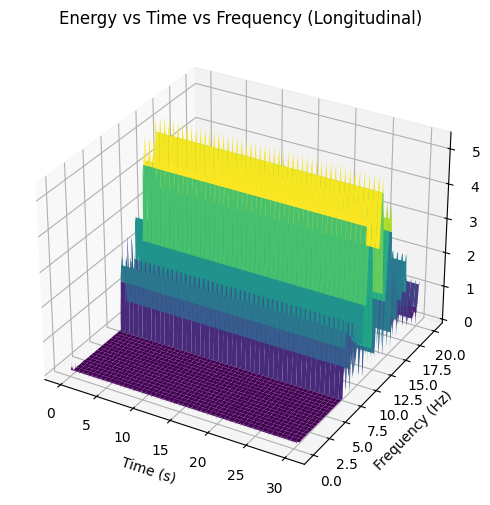

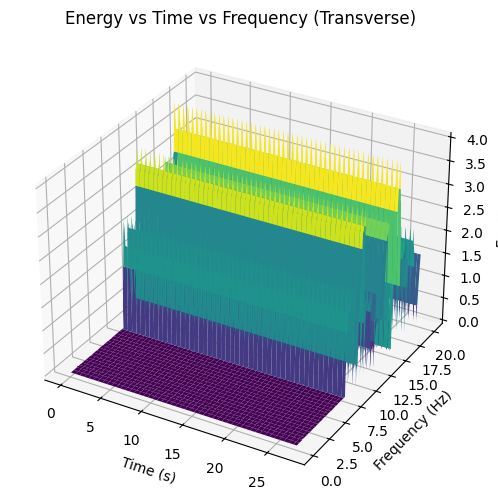

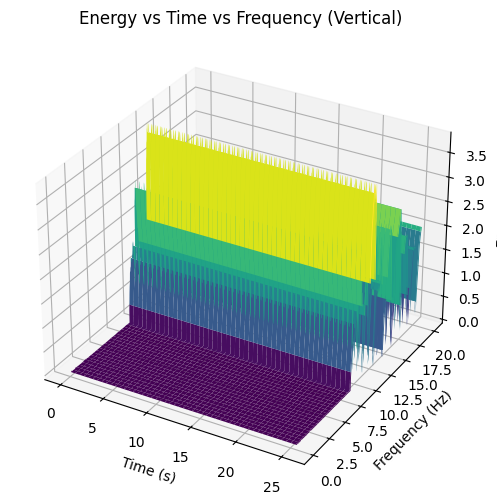

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re  # Regular expressions for filtering out non-numeric lines

def load_numeric_data(filename):
    """Reads a file and extracts only numerical acceleration data."""
    with open(filename, 'r') as f:
        lines = f.readlines()

    numeric_lines = []
    start_reading = False  # Flag to track when numerical data starts

    for line in lines:
        line = line.strip()

        # Skip metadata until we find the line that contains acceleration data
        if re.search(r'Acceleration data points', line):
            start_reading = True
            continue  # Move to the next line

        if start_reading:
            parts = line.split()

            # Ensure all parts are numeric (handling scientific notation)
            if all(re.match(r'^-?\d+(\.\d+)?(E[-+]?\d+)?$', part) for part in parts):
                numeric_lines.append(line)

    # Convert extracted numerical lines into a 1D NumPy array
    if numeric_lines:
        data = np.array([float(val) for line in numeric_lines for val in line.split()])
        return data
    else:
        raise ValueError(f"No numeric data found in {filename}")

def plot_energy_surface(Ts, Ws, GTW, title):
    """Plots a 3D surface for energy vs time vs frequency."""
    Ts, Ws = np.meshgrid(Ts, Ws)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Ts, Ws, GTW, cmap='viridis')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_zlabel('Energy')
    ax.set_title(title)
    plt.show()

# File paths
files = [
      '/content/india.199110192123.arudr.l',
     '/content/india.199110192123.arudr.t',
     '/content/india.199110192123.arudr.v'
]

# Corresponding labels
labels = ["Longitudinal", "Transverse", "Vertical"]

# Load and process data
for i, file in enumerate(files):
    try:
        data = load_numeric_data(file)

        # Generate a time axis (assuming 0.02 sec intervals)
        Ts = np.linspace(0, len(data) * 0.02, len(data))
        Ws = np.linspace(0.1, 20, len(data))  # Placeholder frequency range

        # Ensure reshaping for plotting
        GTW = data.reshape((len(Ts), -1)) if data.size % len(Ts) == 0 else data.reshape(len(Ts), 1)

        plot_energy_surface(Ts, Ws, GTW, f'Energy vs Time vs Frequency ({labels[i]})')
    except Exception as e:
        print(f"Error processing {file}: {e}")

Response spectrum

<ipython-input-6-3fabb5a780e0>:72: RuntimeWarning: overflow encountered in scalar add
  df = -(Ag[i + 1] - Ag[i]) + a * v[i] + b * ac[i]  # Delta force
<ipython-input-6-3fabb5a780e0>:74: RuntimeWarning: invalid value encountered in scalar subtract
  dv = 3 * du / dt - 3 * v[i] - dt * ac[i] / 2
<ipython-input-6-3fabb5a780e0>:75: RuntimeWarning: invalid value encountered in scalar subtract
  dac = 6 * (du - dt * v[i]) / dt**2 - 3 * ac[i]
<ipython-input-6-3fabb5a780e0>:72: RuntimeWarning: overflow encountered in scalar multiply
  df = -(Ag[i + 1] - Ag[i]) + a * v[i] + b * ac[i]  # Delta force
<ipython-input-6-3fabb5a780e0>:75: RuntimeWarning: overflow encountered in scalar multiply
  dac = 6 * (du - dt * v[i]) / dt**2 - 3 * ac[i]


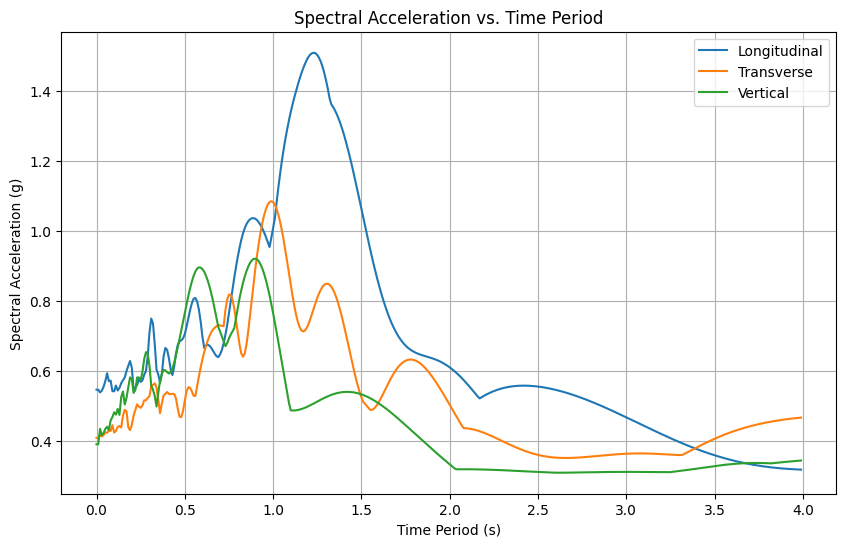

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import re

def load_numeric_data(filename):
    """Reads a file and extracts only numerical acceleration data."""
    with open(filename, 'r') as f:
        lines = f.readlines()

    numeric_lines = []
    start_reading = False  # Flag to track when numerical data starts

    for line in lines:
        line = line.strip()

        # Skip metadata until we find the line that contains acceleration data
        if re.search(r'Acceleration data points', line):
            start_reading = True
            continue  # Move to the next line

        if start_reading:
            parts = line.split()

            # Ensure all parts are numeric (handling scientific notation)
            if all(re.match(r'^-?\d+(\.\d+)?(E[-+]?\d+)?$', part) for part in parts):
                numeric_lines.append(line)

    # Convert extracted numerical lines into a 1D NumPy array
    if numeric_lines:
        data = np.array([float(val) for line in numeric_lines for val in line.split()])
        return data
    else:
        raise ValueError(f"No numeric data found in {filename}")

def compute_spectral_response(dt, Ag, zet=5, g=9.81, endp=4):
    """
    Computes spectral acceleration (Spa), velocity (Spv), and displacement (Sd)
    using the Newmark linear method.

    dt  : Time step (s)
    Ag  : Ground acceleration (m/s²)
    zet : Damping ratio (%) (default: 5%)
    g   : Gravity (m/s²) (default: 9.81)
    endp: Maximum time period (s) (default: 4 sec)
    """
    Ag = np.append(Ag, 0)  # Append zero at the end
    num_steps = round(endp / dt)

    T = np.zeros(num_steps)
    Sd = np.zeros(num_steps)
    Spv = np.zeros(num_steps)
    Spa = np.zeros(num_steps)

    for j in range(num_steps):
        T[j] = j * dt if j > 0 else 0.00  # Time period
        if T[j] == 0:
            continue

        omega = 2 * np.pi / T[j]  # Natural frequency
        m = 1
        k = omega ** 2 * m
        c = 2 * m * omega * zet / 100
        K = k + 3 * c / dt + 6 * m / dt**2
        a = 6 * m / dt + 3 * c
        b = 3 * m + dt * c / 2

        u = np.zeros(len(Ag))
        v = np.zeros(len(Ag))
        ac = np.zeros(len(Ag))

        for i in range(len(Ag) - 1):
            df = -(Ag[i + 1] - Ag[i]) + a * v[i] + b * ac[i]  # Delta force
            du = df / K
            dv = 3 * du / dt - 3 * v[i] - dt * ac[i] / 2
            dac = 6 * (du - dt * v[i]) / dt**2 - 3 * ac[i]

            u[i + 1] = u[i] + du
            v[i + 1] = v[i] + dv
            ac[i + 1] = ac[i] + dac

        Sd[j] = np.max(np.abs(u))  # Max displacement
        Spv[j] = Sd[j] * omega  # Spectral velocity
        Spa[j] = (Sd[j] * omega**2) / g  # Spectral acceleration

    # Fixing edge case for Spa
    Spa[:2] = np.max(np.abs(Ag)) / g

    return T, Spa, Spv, Sd

# File paths
files = [
    '/content/india.199110192123.arudr.l',
    '/content/india.199110192123.arudr.t',
    '/content/india.199110192123.arudr.v'
]

# Corresponding labels
labels = ["Longitudinal", "Transverse", "Vertical"]

# Time step (dt) and simulation parameters
dt = 0.01  # Time step (s)
zet = 5  # Damping ratio in %
endp = 4  # Max time period (s)

plt.figure(figsize=(10, 6))

# Process each file
for i, file in enumerate(files):
    try:
        Ag = load_numeric_data(file)
        T, Spa, Spv, Sd = compute_spectral_response(dt, Ag, zet, endp=endp)

        # Plot Spectral Acceleration vs. Time Period
        plt.plot(T, Spa, label=labels[i])

    except Exception as e:
        print(f"Error processing {file}: {e}")

# Plot settings
plt.xlabel("Time Period (s)")
plt.ylabel("Spectral Acceleration (g)")
plt.title("Spectral Acceleration vs. Time Period")
plt.legend()
plt.grid()
plt.show()


Fourier response spectrum

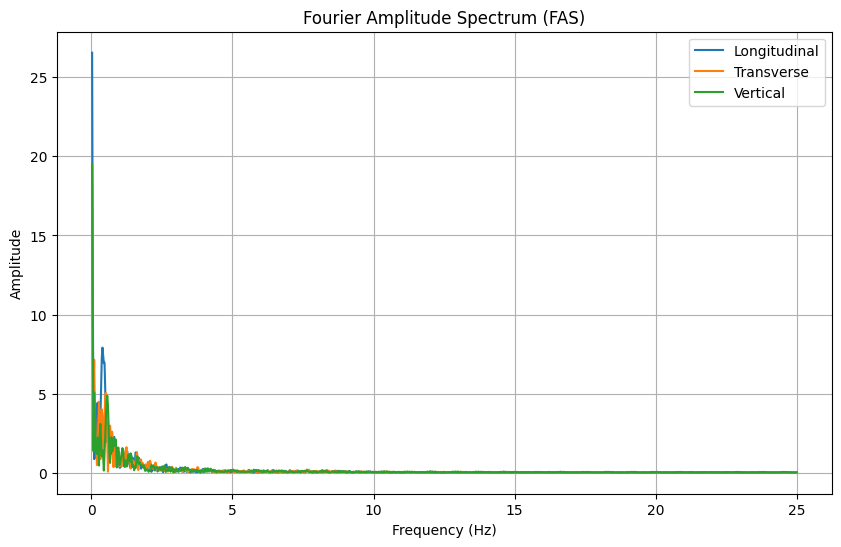

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import re  # Regular expressions for filtering out non-numeric lines

def load_numeric_data(filename):
    """Reads a file and extracts only numerical acceleration data."""
    with open(filename, 'r') as f:
        lines = f.readlines()

    numeric_lines = []
    start_reading = False  # Flag to track when numerical data starts

    for line in lines:
        line = line.strip()

        # Skip metadata until we find the line that contains acceleration data
        if re.search(r'Acceleration data points', line):
            start_reading = True
            continue  # Move to the next line

        if start_reading:
            parts = line.split()

            # Ensure all parts are numeric (handling scientific notation)
            if all(re.match(r'^-?\d+(\.\d+)?(E[-+]?\d+)?$', part) for part in parts):
                numeric_lines.append(line)

    # Convert extracted numerical lines into a 1D NumPy array
    if numeric_lines:
        data = np.array([float(val) for line in numeric_lines for val in line.split()])
        return data
    else:
        raise ValueError(f"No numeric data found in {filename}")

def compute_fas(dt, xgtt):
    """Computes the Fourier Amplitude Spectrum (FAS)."""
    if dt <= 0:
        raise ValueError("dt must be positive")

    if not isinstance(xgtt, np.ndarray) or xgtt.ndim != 1:
        raise ValueError("xgtt must be a 1D numpy array")

    Ny = (1 / dt) / 2  # Nyquist frequency
    L = len(xgtt)
    NFFT = 2 ** int(np.ceil(np.log2(L)))  # Next power of 2 for FFT efficiency
    df = 1 / (NFFT * dt)  # Frequency spacing

    U = np.abs(np.fft.fft(xgtt, NFFT)) * dt  # Fourier amplitudes
    U = U[1:int(Ny / df) + 1]  # Trim values beyond Nyquist frequency
    f = np.linspace(df, Ny, int(Ny / df))  # Frequency range

    return f, U

def plot_fas(frequencies, amplitudes, label):
    """Plots Fourier Amplitude Spectrum (Amplitude vs Frequency)."""
    plt.plot(frequencies, amplitudes, label=label)

# File paths
files = [
      '/content/india.199110192123.arudr.l',
     '/content/india.199110192123.arudr.t',
     '/content/india.199110192123.arudr.v'
]

# Corresponding labels
labels = ["Longitudinal", "Transverse", "Vertical"]

# Sampling interval (Assuming 0.02 sec from previous context)
dt = 0.02

plt.figure(figsize=(10, 6))

# Load and process data for each file
for i, file in enumerate(files):
    try:
        data = load_numeric_data(file)
        f, U = compute_fas(dt, data)
        plot_fas(f, U, labels[i])
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Final plot adjustments
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Fourier Amplitude Spectrum (FAS)")
plt.legend()
plt.grid(True)
plt.show()

Asrin

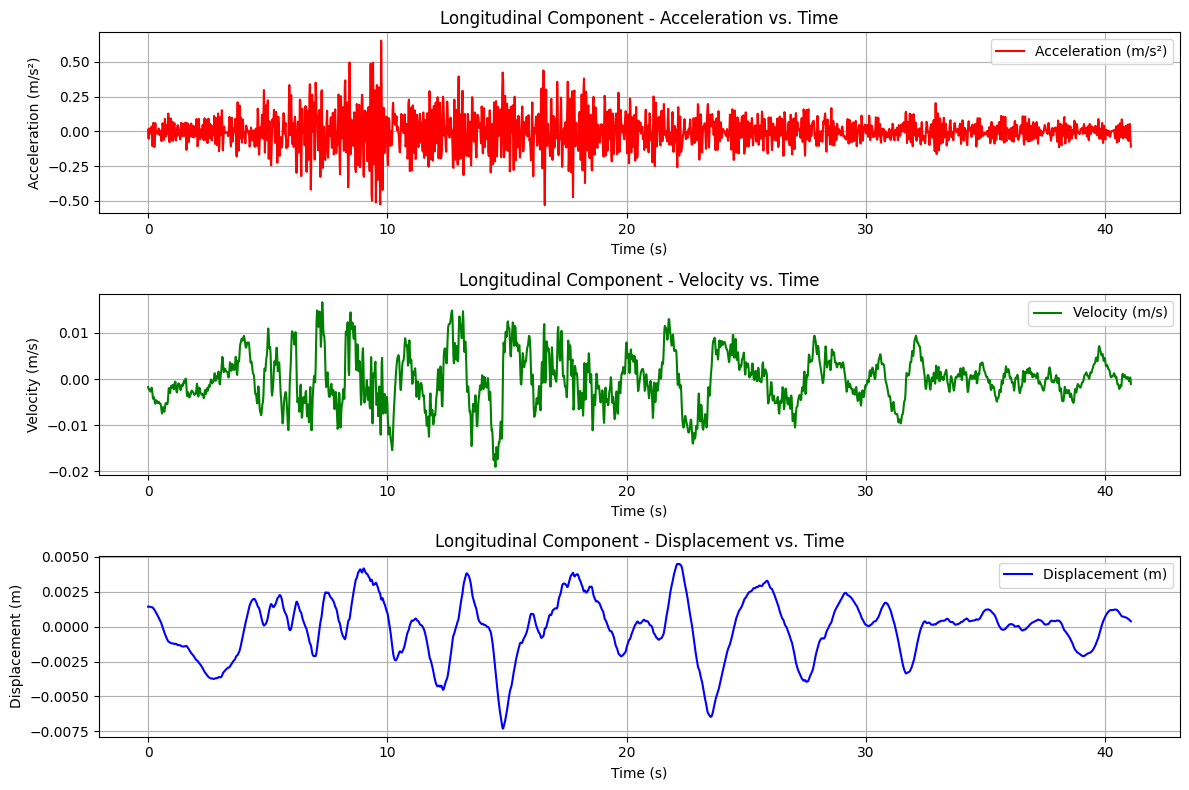

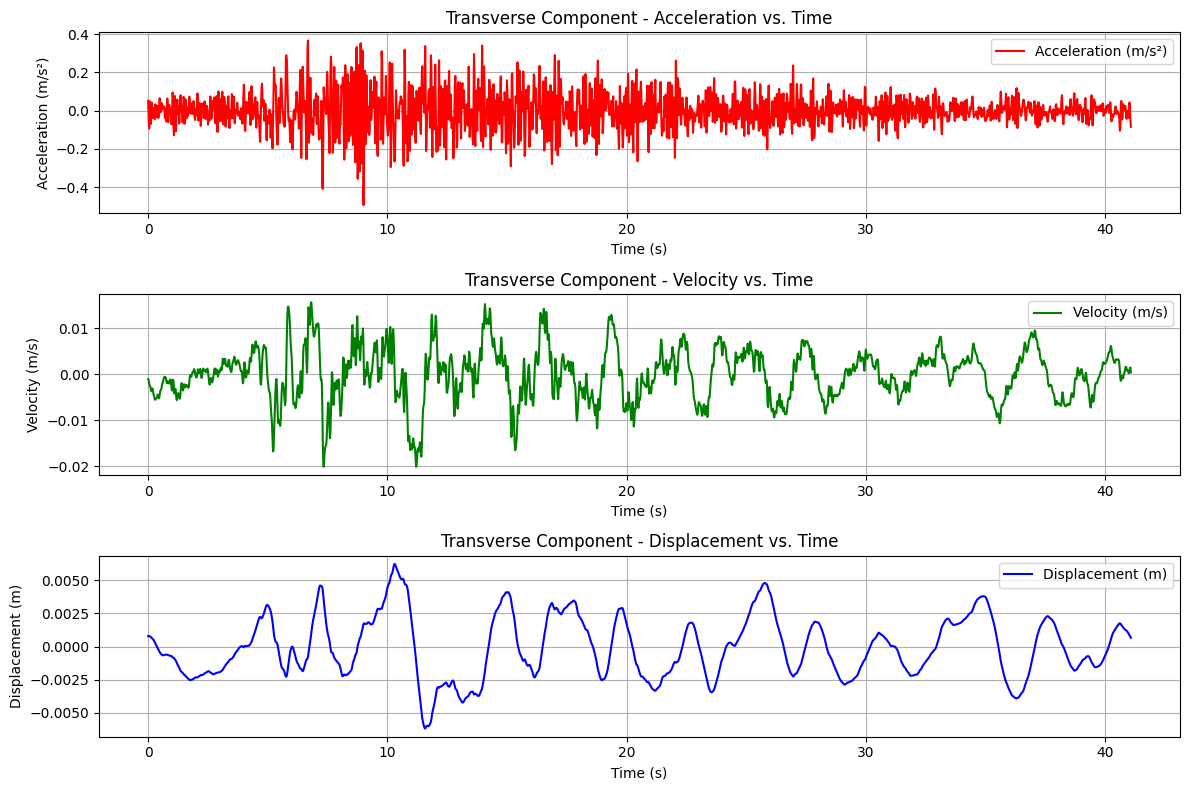

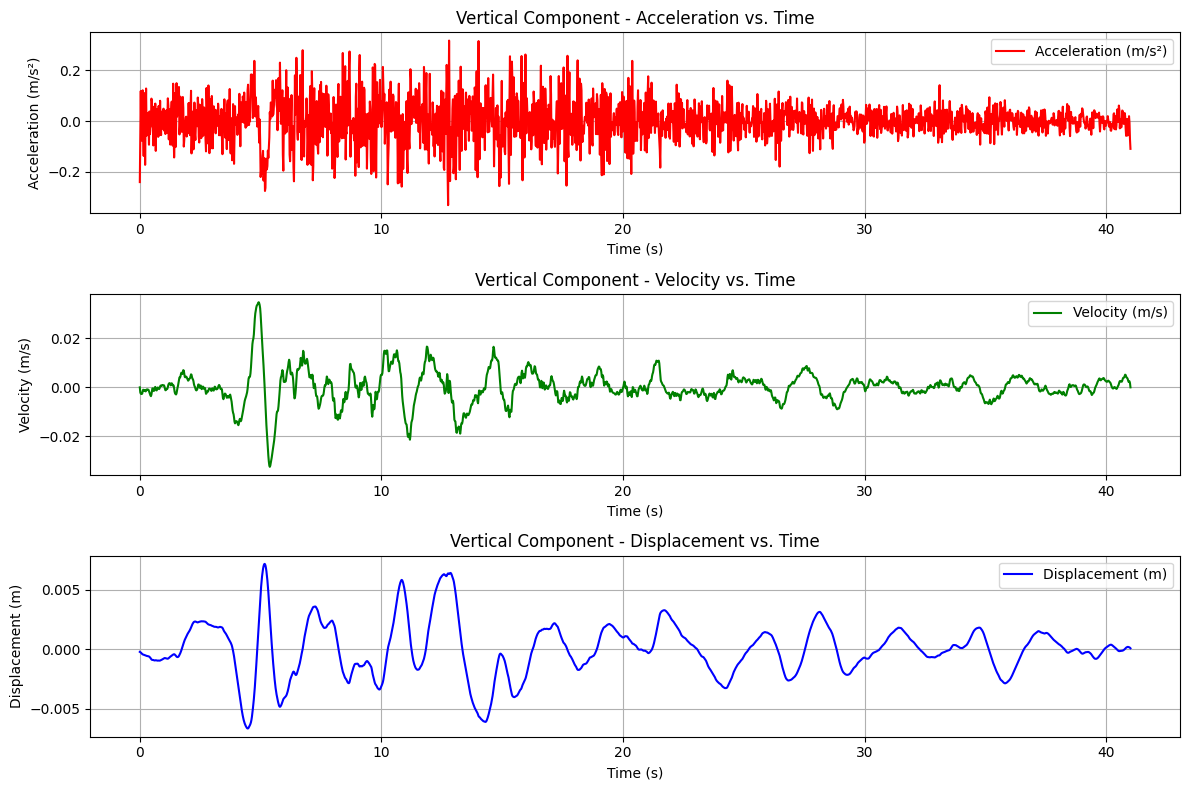


Longitudinal Component:
Velocity (first 5 values): [-0.00172499 -0.00218052 -0.00231677 -0.00230615 -0.00250032]
Displacement (first 5 values): [0.00143442 0.00143662 0.00143535 0.00143089 0.00142342]

Transverse Component:
Velocity (first 5 values): [-0.00107205 -0.00135582 -0.00201557 -0.00253049 -0.00261316]
Displacement (first 5 values): [0.00078722 0.0008016  0.00080058 0.0007853  0.00076612]

Vertical Component:
Velocity (first 5 values): [-9.41005995e-05 -2.13818057e-03 -2.66777124e-03 -2.55584704e-03
 -2.80733702e-03]
Displacement (first 5 values): [-0.00021557 -0.00024199 -0.00027129 -0.00030743 -0.0003521 ]


In [ ]:
import numpy as np
import scipy.signal as signal
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import pandas as pd

def read_acceleration_file(filename):
    """Reads an earthquake acceleration data file and extracts metadata + acceleration values."""
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Extract time step (delt)
    for line in lines:
        if "Acceleration data points" in line and "sec" in line:
            words = line.split()
            for i, word in enumerate(words):
                if word == "at":
                    try:
                        delt = float(words[i + 1])  # Extract time step
                        break
                    except ValueError:
                        raise ValueError(f"Error parsing time step from line: {line}")
            break
    else:
        raise ValueError("Could not find time step in file.")

    # Extract acceleration values
    acc_data = []
    data_section = False
    for line in lines:
        if "Acceleration data points" in line:
            data_section = True
            continue

        if data_section:
            try:
                acc_values = list(map(float, line.replace("E", "e").split()))
                acc_data.extend(acc_values)
            except ValueError:
                break  # Stop reading on non-numeric data

    if not acc_data:
        raise ValueError("No acceleration data found in file.")

    return np.array(acc_data), delt

def acc_to_disp(acc, delt):
    """Computes velocity and displacement from acceleration using integration and filtering."""
    t = np.arange(len(acc)) * delt

    # Compute velocity and displacement using numerical integration
    velocity = integrate.cumulative_trapezoid(acc, t, initial=0)
    displacement = integrate.cumulative_trapezoid(velocity, t, initial=0)

    # Apply Butterworth filter
    fo = 0.1  # Lower cutoff frequency
    fc = 1 / (2 * delt)  # Nyquist frequency
    nf = 0.5 * fc  # Upper cutoff (set to avoid aliasing)
    b, a = signal.butter(4, np.array([fo, nf]) / fc, btype='bandpass')

    velocity_filtered = signal.filtfilt(b, a, velocity)
    displacement_filtered = signal.filtfilt(b, a, displacement)

    return t, velocity_filtered, displacement_filtered

def plot_results(component, t, acc, velocity, displacement):
    """Plots Acceleration, Velocity, and Displacement vs. Time."""
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(t, acc, 'r', label="Acceleration (m/s²)")
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s²)")
    plt.title(f"{component.capitalize()} Component - Acceleration vs. Time")
    plt.legend()
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.plot(t, velocity, 'g', label="Velocity (m/s)")
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m/s)")
    plt.title(f"{component.capitalize()} Component - Velocity vs. Time")
    plt.legend()
    plt.grid()

    plt.subplot(3, 1, 3)
    plt.plot(t, displacement, 'b', label="Displacement (m)")
    plt.xlabel("Time (s)")
    plt.ylabel("Displacement (m)")
    plt.title(f"{component.capitalize()} Component - Displacement vs. Time")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Load and process data files
files = {
    "longitudinal": "/content/india.199110192123.asrin.l",
    "transverse": "/content/india.199110192123.asrin.t",
    "vertical": "/content/india.199110192123.asrin.v"
}

results = {}
for component, file in files.items():
    acc, delt = read_acceleration_file(file)
    t, velocity, displacement = acc_to_disp(acc, delt)

    # Save results to CSV
    df = pd.DataFrame({"Time (s)": t, "Acceleration (m/s²)": acc, "Velocity (m/s)": velocity, "Displacement (m)": displacement})
    df.to_csv(f"{component}_results.csv", index=False)

    results[component] = {"time": t, "acceleration": acc, "velocity": velocity, "displacement": displacement}
    plot_results(component, t, acc, velocity, displacement)

# Print Sample Results
for comp in results:
    print(f"\n{comp.capitalize()} Component:")
    print(f"Velocity (first 5 values): {results[comp]['velocity'][:5]}")
    print(f"Displacement (first 5 values): {results[comp]['displacement'][:5]}")


In [ ]:
import numpy as np
import scipy.signal as signal
import scipy.integrate as integrate
import pandas as pd

def read_acceleration_file(filename):
    """Reads an earthquake acceleration data file and extracts acceleration values & time step."""
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Extract time step
    delt = None
    for line in lines:
        if "Acceleration data points" in line and "sec" in line:
            words = line.split()
            for i, word in enumerate(words):
                if word == "at":
                    delt = float(words[i + 1])
                    break
            break
    if delt is None:
        raise ValueError("Time step (delt) not found in the file.")

    # Extract acceleration values
    acc_data = []
    data_section = False
    for line in lines:
        if "Acceleration data points" in line:
            data_section = True
            continue
        if data_section:
            try:
                acc_values = list(map(float, line.replace("E", "e").split()))
                acc_data.extend(acc_values)
            except ValueError:
                break

    return np.array(acc_data), delt

def acc_to_disp(acc, delt):
    """Computes velocity and displacement from acceleration."""
    n = len(acc)
    t = np.arange(0, n * delt, delt)[:n]  # Ensure t has the same length as acc

    velocity = integrate.cumulative_trapezoid(acc, t, initial=0)
    displacement = integrate.cumulative_trapezoid(velocity, t, initial=0)
    return t, velocity, displacement

def compute_gmps(acc, delt):
    """Computes 21 Ground Motion Parameters (GMPs)."""
    fs = 1 / delt  # Sampling frequency
    t, velocity, displacement = acc_to_disp(acc, delt)

    # 1. Peak Ground Acceleration (PGA)
    PGA = np.max(np.abs(acc)) / 9.81

    # 2. Peak Ground Velocity (PGV)
    PGV = np.max(np.abs(velocity))

    # 3. Peak Ground Displacement (PGD)
    PGD = np.max(np.abs(displacement))

    # 4. PGV/PGA Ratio
    VbyA = PGV / PGA if PGA != 0 else 0

    # 5. Predominant Frequency using PSD
    f, Pxx = signal.welch(acc, fs=fs)
    Fp = f[np.argmax(Pxx)] if len(f) > 0 else 0

    # 6. Central Frequency
    lambda0 = np.trapz(Pxx, f) if len(f) > 0 else 1
    lambda2 = np.trapz(f**2 * Pxx, f) if len(f) > 0 else 1
    Omega = np.sqrt(lambda2 / lambda0) if lambda0 != 0 else 0

    # 7. Spectral Parameter (q)
    lambda1 = np.trapz(f * Pxx, f) if len(f) > 0 else 1
    q = np.sqrt(1 - ((lambda1**2) / (lambda0 * lambda2))) if (lambda0 * lambda2) != 0 else 0

    # 8. Arias Intensity
    AI = np.trapz(acc**2, t) * (np.pi / (2 * 9.81))

    # 9. Cumulative Absolute Velocity (CAV)
    CAV = np.trapz(np.abs(acc), t)

    # 10. Root Mean Square Acceleration (aRMS)
    aRMS = np.sqrt(np.mean(acc**2)) / 9.81

    # Spectral Analysis for ASI and VSI (0.1-0.5Hz and 0.1-2.5Hz ranges)
    lim1, lim2 = int(0.1 * fs), int(0.5 * fs)
    lim3 = int(2.5 * fs)

    ASI = np.trapz(Pxx[lim1:lim2], f[lim1:lim2]) * 9.81 if len(f) > lim2 else 0
    VSI = np.trapz(Pxx[lim1:lim3], f[lim1:lim3]) * 9.81 if len(f) > lim3 else 0

    # Placeholder for more advanced spectral calculations
    epsd7 = [0] * 7  # Replace with actual EPSD calculations

    return [PGA, PGV, PGD, VbyA, Fp, Omega, q, AI, CAV, aRMS, ASI, VSI] + epsd7

# Load and process all 3 components
files = {
     "longitudinal": '/content/india.199110192123.asrin.l',
    "transverse": '/content/india.199110192123.asrin.t',
    "vertical": '/content/india.199110192123.asrin.v'
}

results = {}
for component, file in files.items():
    acc, delt = read_acceleration_file(file)
    gmp_values = compute_gmps(acc, delt)

    df = pd.DataFrame([gmp_values], columns=[
        "PGA (g)", "PGV (cm/s)", "PGD (cm)", "PGV/PGA (s)", "Fp (Hz)",
        "Omega (Hz)", "q", "AI (cm/s)", "CAV (cm/s)", "aRMS (g)",
        "ASI (cm/s)", "VSI (cm)" ] + [f"EPSD_{i+1}" for i in range(7)]
    )

    df.to_csv(f"{component}_GMPs.csv", index=False)
    results[component] = df

print("GMPs calculated and saved for all components.")


GMPs calculated and saved for all components.


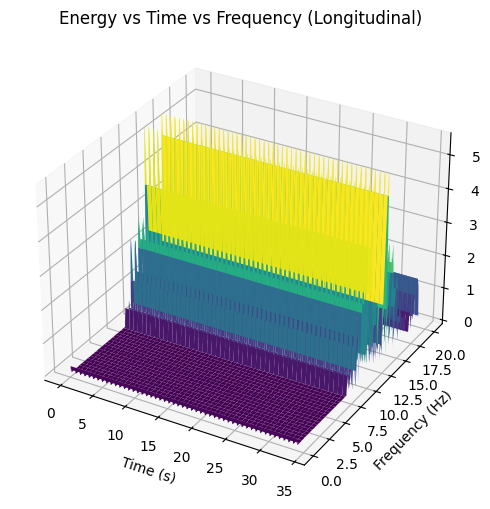

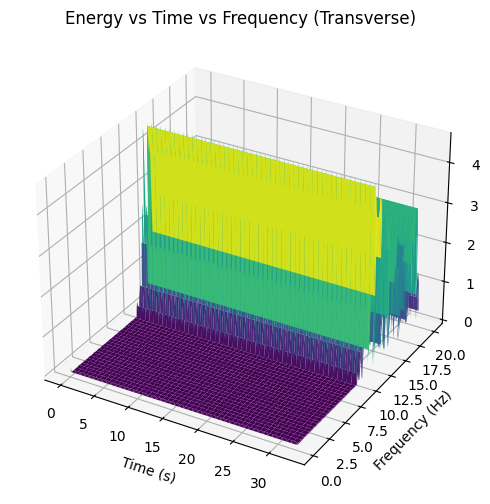

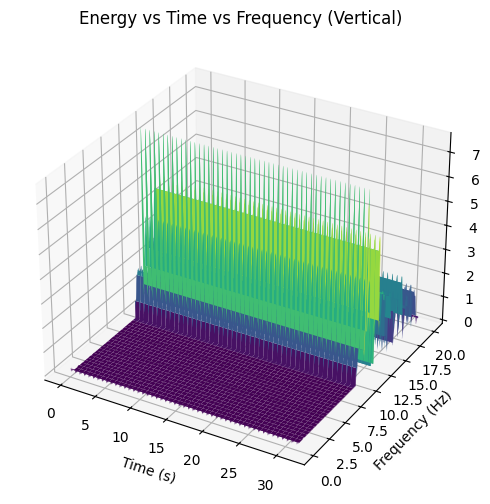

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re  # Regular expressions for filtering out non-numeric lines

def load_numeric_data(filename):
    """Reads a file and extracts only numerical acceleration data."""
    with open(filename, 'r') as f:
        lines = f.readlines()

    numeric_lines = []
    start_reading = False  # Flag to track when numerical data starts

    for line in lines:
        line = line.strip()

        # Skip metadata until we find the line that contains acceleration data
        if re.search(r'Acceleration data points', line):
            start_reading = True
            continue  # Move to the next line

        if start_reading:
            parts = line.split()

            # Ensure all parts are numeric (handling scientific notation)
            if all(re.match(r'^-?\d+(\.\d+)?(E[-+]?\d+)?$', part) for part in parts):
                numeric_lines.append(line)

    # Convert extracted numerical lines into a 1D NumPy array
    if numeric_lines:
        data = np.array([float(val) for line in numeric_lines for val in line.split()])
        return data
    else:
        raise ValueError(f"No numeric data found in {filename}")

def plot_energy_surface(Ts, Ws, GTW, title):
    """Plots a 3D surface for energy vs time vs frequency."""
    Ts, Ws = np.meshgrid(Ts, Ws)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Ts, Ws, GTW, cmap='viridis')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_zlabel('Energy')
    ax.set_title(title)
    plt.show()

# File paths
files = [
      '/content/india.199110192123.asrin.l',
     '/content/india.199110192123.asrin.t',
     '/content/india.199110192123.asrin.v'
]

# Corresponding labels
labels = ["Longitudinal", "Transverse", "Vertical"]

# Load and process data
for i, file in enumerate(files):
    try:
        data = load_numeric_data(file)

        # Generate a time axis (assuming 0.02 sec intervals)
        Ts = np.linspace(0, len(data) * 0.02, len(data))
        Ws = np.linspace(0.1, 20, len(data))  # Placeholder frequency range

        # Ensure reshaping for plotting
        GTW = data.reshape((len(Ts), -1)) if data.size % len(Ts) == 0 else data.reshape(len(Ts), 1)

        plot_energy_surface(Ts, Ws, GTW, f'Energy vs Time vs Frequency ({labels[i]})')
    except Exception as e:
        print(f"Error processing {file}: {e}")

<ipython-input-12-336bb806e918>:72: RuntimeWarning: overflow encountered in scalar multiply
  df = -(Ag[i + 1] - Ag[i]) + a * v[i] + b * ac[i]  # Delta force
<ipython-input-12-336bb806e918>:75: RuntimeWarning: overflow encountered in scalar multiply
  dac = 6 * (du - dt * v[i]) / dt**2 - 3 * ac[i]
<ipython-input-12-336bb806e918>:75: RuntimeWarning: invalid value encountered in scalar subtract
  dac = 6 * (du - dt * v[i]) / dt**2 - 3 * ac[i]
<ipython-input-12-336bb806e918>:74: RuntimeWarning: invalid value encountered in scalar subtract
  dv = 3 * du / dt - 3 * v[i] - dt * ac[i] / 2


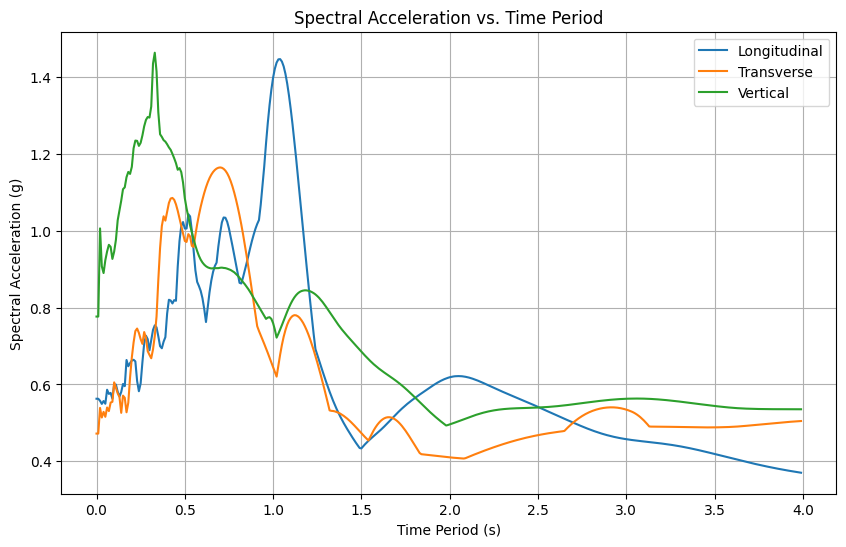

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import re

def load_numeric_data(filename):
    """Reads a file and extracts only numerical acceleration data."""
    with open(filename, 'r') as f:
        lines = f.readlines()

    numeric_lines = []
    start_reading = False  # Flag to track when numerical data starts

    for line in lines:
        line = line.strip()

        # Skip metadata until we find the line that contains acceleration data
        if re.search(r'Acceleration data points', line):
            start_reading = True
            continue  # Move to the next line

        if start_reading:
            parts = line.split()

            # Ensure all parts are numeric (handling scientific notation)
            if all(re.match(r'^-?\d+(\.\d+)?(E[-+]?\d+)?$', part) for part in parts):
                numeric_lines.append(line)

    # Convert extracted numerical lines into a 1D NumPy array
    if numeric_lines:
        data = np.array([float(val) for line in numeric_lines for val in line.split()])
        return data
    else:
        raise ValueError(f"No numeric data found in {filename}")

def compute_spectral_response(dt, Ag, zet=5, g=9.81, endp=4):
    """
    Computes spectral acceleration (Spa), velocity (Spv), and displacement (Sd)
    using the Newmark linear method.

    dt  : Time step (s)
    Ag  : Ground acceleration (m/s²)
    zet : Damping ratio (%) (default: 5%)
    g   : Gravity (m/s²) (default: 9.81)
    endp: Maximum time period (s) (default: 4 sec)
    """
    Ag = np.append(Ag, 0)  # Append zero at the end
    num_steps = round(endp / dt)

    T = np.zeros(num_steps)
    Sd = np.zeros(num_steps)
    Spv = np.zeros(num_steps)
    Spa = np.zeros(num_steps)

    for j in range(num_steps):
        T[j] = j * dt if j > 0 else 0.00  # Time period
        if T[j] == 0:
            continue

        omega = 2 * np.pi / T[j]  # Natural frequency
        m = 1
        k = omega ** 2 * m
        c = 2 * m * omega * zet / 100
        K = k + 3 * c / dt + 6 * m / dt**2
        a = 6 * m / dt + 3 * c
        b = 3 * m + dt * c / 2

        u = np.zeros(len(Ag))
        v = np.zeros(len(Ag))
        ac = np.zeros(len(Ag))

        for i in range(len(Ag) - 1):
            df = -(Ag[i + 1] - Ag[i]) + a * v[i] + b * ac[i]  # Delta force
            du = df / K
            dv = 3 * du / dt - 3 * v[i] - dt * ac[i] / 2
            dac = 6 * (du - dt * v[i]) / dt**2 - 3 * ac[i]

            u[i + 1] = u[i] + du
            v[i + 1] = v[i] + dv
            ac[i + 1] = ac[i] + dac

        Sd[j] = np.max(np.abs(u))  # Max displacement
        Spv[j] = Sd[j] * omega  # Spectral velocity
        Spa[j] = (Sd[j] * omega**2) / g  # Spectral acceleration

    # Fixing edge case for Spa
    Spa[:2] = np.max(np.abs(Ag)) / g

    return T, Spa, Spv, Sd

# File paths
files = [
    '/content/india.199110192123.asrin.l',
    '/content/india.199110192123.asrin.t',
    '/content/india.199110192123.asrin.v'
]

# Corresponding labels
labels = ["Longitudinal", "Transverse", "Vertical"]

# Time step (dt) and simulation parameters
dt = 0.01  # Time step (s)
zet = 5  # Damping ratio in %
endp = 4  # Max time period (s)

plt.figure(figsize=(10, 6))

# Process each file
for i, file in enumerate(files):
    try:
        Ag = load_numeric_data(file)
        T, Spa, Spv, Sd = compute_spectral_response(dt, Ag, zet, endp=endp)

        # Plot Spectral Acceleration vs. Time Period
        plt.plot(T, Spa, label=labels[i])

    except Exception as e:
        print(f"Error processing {file}: {e}")

# Plot settings
plt.xlabel("Time Period (s)")
plt.ylabel("Spectral Acceleration (g)")
plt.title("Spectral Acceleration vs. Time Period")
plt.legend()
plt.grid()
plt.show()

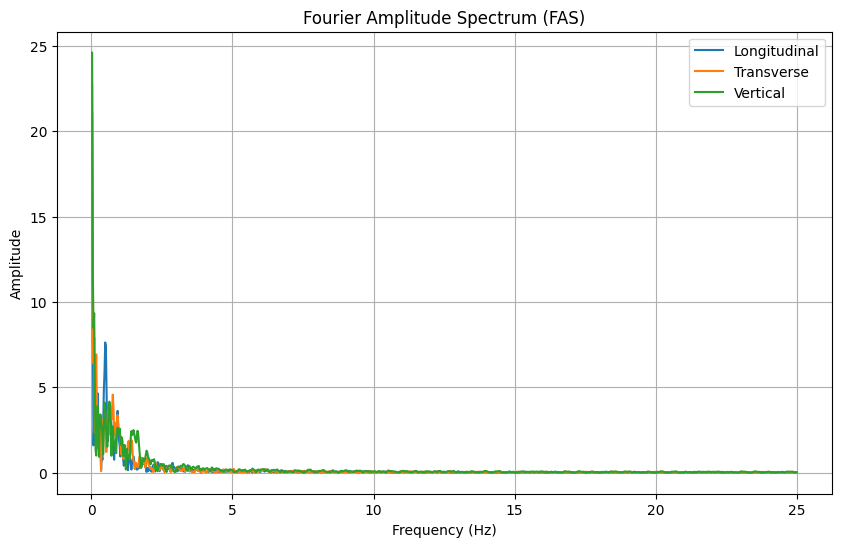

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import re  # Regular expressions for filtering out non-numeric lines

def load_numeric_data(filename):
    """Reads a file and extracts only numerical acceleration data."""
    with open(filename, 'r') as f:
        lines = f.readlines()

    numeric_lines = []
    start_reading = False  # Flag to track when numerical data starts

    for line in lines:
        line = line.strip()

        # Skip metadata until we find the line that contains acceleration data
        if re.search(r'Acceleration data points', line):
            start_reading = True
            continue  # Move to the next line

        if start_reading:
            parts = line.split()

            # Ensure all parts are numeric (handling scientific notation)
            if all(re.match(r'^-?\d+(\.\d+)?(E[-+]?\d+)?$', part) for part in parts):
                numeric_lines.append(line)

    # Convert extracted numerical lines into a 1D NumPy array
    if numeric_lines:
        data = np.array([float(val) for line in numeric_lines for val in line.split()])
        return data
    else:
        raise ValueError(f"No numeric data found in {filename}")

def compute_fas(dt, xgtt):
    """Computes the Fourier Amplitude Spectrum (FAS)."""
    if dt <= 0:
        raise ValueError("dt must be positive")

    if not isinstance(xgtt, np.ndarray) or xgtt.ndim != 1:
        raise ValueError("xgtt must be a 1D numpy array")

    Ny = (1 / dt) / 2  # Nyquist frequency
    L = len(xgtt)
    NFFT = 2 ** int(np.ceil(np.log2(L)))  # Next power of 2 for FFT efficiency
    df = 1 / (NFFT * dt)  # Frequency spacing

    U = np.abs(np.fft.fft(xgtt, NFFT)) * dt  # Fourier amplitudes
    U = U[1:int(Ny / df) + 1]  # Trim values beyond Nyquist frequency
    f = np.linspace(df, Ny, int(Ny / df))  # Frequency range

    return f, U

def plot_fas(frequencies, amplitudes, label):
    """Plots Fourier Amplitude Spectrum (Amplitude vs Frequency)."""
    plt.plot(frequencies, amplitudes, label=label)

# File paths
files = [
      '/content/india.199110192123.asrin.l',
     '/content/india.199110192123.asrin.t',
     '/content/india.199110192123.asrin.v'
]

# Corresponding labels
labels = ["Longitudinal", "Transverse", "Vertical"]

# Sampling interval (Assuming 0.02 sec from previous context)
dt = 0.02

plt.figure(figsize=(10, 6))

# Load and process data for each file
for i, file in enumerate(files):
    try:
        data = load_numeric_data(file)
        f, U = compute_fas(dt, data)
        plot_fas(f, U, labels[i])
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Final plot adjustments
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Fourier Amplitude Spectrum (FAS)")
plt.legend()
plt.grid(True)
plt.show()